# Parametric UMAP

This notebook walks you through the basic algorithm for Parametric UMAP (anonymized for ICLR) in a more verbose (but still high-level) way. 

The code used in the implementation subclasses umap.UMAP and replaces the fit method with a neural network. Here, we'll go through the algorithm, starting with graph construction, one step at a time. 


### Install packages

In [1]:
!pip install llvmlite>=0.34.0

In [2]:
!pip install --upgrade pynndescent

  Using cached pynndescent-0.5.8-py3-none-any.whl
  Using cached scipy-1.9.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scikit_learn-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
  Using cached numba-0.56.4-cp39-cp39-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.5 MB)
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0


In [3]:
!pip install https://github.com/lmcinnes/umap/archive/0.5dev.zip

     \ 39.2 MB 5.0 MB/s 0:00:08
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.0rc1-py3-none-any.whl size=77346 sha256=2368da0fb79e79d924e96d7d0a6adab3fa8825b98b21946ca5fff970a1e873f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-plhmix6p/wheels/f5/3f/75/abb1dbbf257809d3cee5adbbea11c17c19e656ee6df5211bcb
Successfully built umap-learn


### load dataset
We will use MNIST for this example.

In [58]:
from torchvision.datasets import MNIST
import torchvision
from torchvision.transforms import transforms
import torch

In [59]:
# load dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_tensor = torch.stack([example[0] for example in train_dataset])[:, 0][:, None, ...]
test_tensor = torch.stack([example[0] for example in test_dataset])[:, 0][:, None, ...]
X = train_tensor
X.shape

torch.Size([60000, 1, 28, 28])

## Part 1: Building the Graph
The first part of Parametric UMAP is shared with non-parametric UMAP, so we can use the same code. First we build a nearest-neighbors graph, using pynndescent, then we build a fuzzy simplicial complex.

### Build nearest neighbor's graph
We're just building a nearest neighbors graph here. You can play around with replacing this code with your own nearest neighbor estimator if you'd like.

In [60]:
from pynndescent import NNDescent
import numpy as np

In [61]:
# number of trees in random projection forest
n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X.shape[0]))))
# distance metric
metric="euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

# get nearest neighbors
nnd = NNDescent(
    X.reshape((len(X), np.product(np.shape(X)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Thu Dec 29 18:03:30 2022 Building RP forest with 17 trees
Thu Dec 29 18:03:32 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [62]:
# nearest neighbors and distances for each point in the dataset
np.shape(knn_indices), np.shape(knn_dists)

((60000, 10), (60000, 10))

### Build fuzzy simplicial  complex

The `fuzzy_simplicial_set` function takes the nearest neighbor graph and computes a graph of the probabilities of an edge exists between points. 

Local, one-directional, probabilities ($P^{\textrm{UMAP}}_{i|j}$) are computed between a point and its neighbors to determine the probability with which an edge (or simplex exists), based upon an assumption that data is uniformly distributed across a manifold in a warped dataspace. Under this assumption, a local notion of distance is set by the distance to the $k$\textsuperscript{th} nearest neighbor and the local probability is scaled by that local notion of distance.

$$
p_{j \mid i}^{\textrm{UMAP}} = \exp( -(\textrm{d}( \mathbf{x}_{i},\mathbf{x}_{j}) - \rho_{i}) / \sigma_{i})
$$

Where $\rho_{i}$ is a local connectivity parameter set to the distance from $x_i$ to its nearest neighbor, and $\sigma_{i}$ is a local connectivity parameter set to match the local distance around $x_i$ upon its $k$ nearest neighbors (where $k$ is a hyperparameter). In the UMAP package, these are calculated using `smooth_knn_dist`.

After computing the one-directional edge probabilities for each datapoint, we then compute a global probability as the probability of either of the two local, one-directional, probabilities occurring:

$$
p_{i j}=\left(p_{j \mid i}+p_{i \mid j}\right)-p_{j \mid i} p_{i \mid j}
$$

In [63]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set

In [64]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [65]:
# build fuzzy_simplicial_set
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X,
    n_neighbors = n_neighbors,
    metric = metric,
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [66]:
umap_graph

<60000x60000 sparse matrix of type '<class 'numpy.float32'>'
	with 803604 stored elements in Compressed Sparse Row format>

## Part 2: Embedding the graph

Now we learn an embedding for the graph, using a neural network. This is where Parametric UMAP differs from non-parametric UMAP. 

### Create neural network model
We first create a neural network to perform the parametric embedding. Here, we'll use a simple convolutional neural network

In [67]:
import torch
import torch.nn as nn
import torchsummary

In [68]:
dims = X.shape[1:]
dims

torch.Size([1, 28, 28])

In [193]:
n_components = 2 # number of latent dimensions
dims = X.shape[1:]

encoder = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1,
    ),
    nn.Conv2d(
        in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1,
    ),
    nn.Flatten(),
    nn.Linear(6272, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, n_components)
).cuda()

torchsummary.summary(encoder, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
            Conv2d-2            [-1, 128, 7, 7]          73,856
           Flatten-3                 [-1, 6272]               0
            Linear-4                  [-1, 512]       3,211,776
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 512]         262,656
              ReLU-7                  [-1, 512]               0
            Linear-8                    [-1, 2]           1,026
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 13.54
Estimated Total Size (MB): 13.75
----------------------------------------------------------------


### create batch iterator

We now want to create a dataset to iterate over batches of edges and their nearest-neighbors in our dataset. We're basically just creating a tensorflow dataset that iterates over batches of nearest neighbors, based upon the probabilities determined by the graph we produced (higher probability edges are sampled more frequently).  

If you're curious about what's under the hood look at the `construct_edge_dataset` function. Or take a look at the example plot of nearest neighbors below. 

In [51]:
from umap.parametric_umap import construct_edge_dataset

/home/elyx/miniconda3/envs/umap_pt/lib/python3.9/site-packages/umap/parametric_umap.py:16: UserWarning: The umap.parametric_umap package requires Tensorflow > 2.0 to be installed.
    You can install Tensorflow at https://www.tensorflow.org/install
    
    or you can install the CPU version of Tensorflow using 

    pip install umap-learn[parametric_umap]

    
  warn(


ImportError: umap.parametric_umap requires Tensorflow >= 2.0

In [177]:
from torch.utils.data import Dataset, DataLoader
n_epochs = 200 
batch_size = 8 # iterate over batches of 1000 edges

In [71]:
X.shape

torch.Size([60000, 1, 28, 28])

In [88]:
def get_graph_elements(graph_, n_epochs):

    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    epochs_per_sample = n_epochs * graph.data

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices


In [111]:
class UMAPDataset(Dataset):
    def __init__(self, data, graph_, n_epochs):
        graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(graph_, n_epochs)
        
        self.edges_to_exp, self.edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
        np.repeat(tail, epochs_per_sample.astype("int")),
    )
        shuffle_mask = np.random.permutation(np.arange(len(self.edges_to_exp)))
        self.edges_to_exp = self.edges_to_exp[shuffle_mask].astype(np.int64)
        self.edges_from_exp = self.edges_from_exp[shuffle_mask].astype(np.int64)
        self.data = data
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, index):
        edges_to_exp = self.data[self.edges_to_exp[index]]
        edges_from_exp = self.data[self.edges_from_exp[index]]
        return (edges_to_exp, edges_from_exp)

In [113]:
dataset = UMAPDataset(X, umap_graph, n_epochs)
data_loader = DataLoader(dataset, batch_size=8)
(sample_edge_to_x, sample_edge_from_x) = next(iter(data_loader))
sample_edge_to_x.shape

torch.Size([8, 1, 28, 28])

In [103]:

get tensorflow dataset of edges 
(
    edge_dataset,
    batch_size,
    n_edges,
    head,
    tail,
    edge_weight,
) = construct_edge_dataset(
    X,
    umap_graph,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = False,
)

NameError: name 'construct_edge_dataset' is not defined

In [82]:
(sample_edge_to_x, sample_edge_from_x), _ =  next(iter(edge_dataset))
sample_edge_to_x.shape

NameError: name 'edge_dataset' is not defined

In [83]:
import matplotlib.pyplot as plt

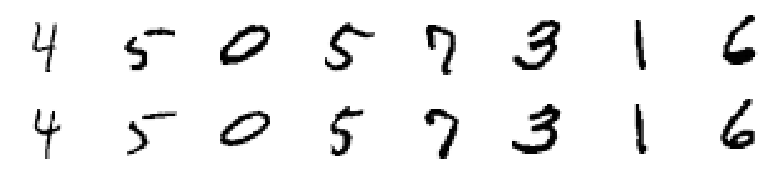

In [114]:
# plot sampled neighbors from graph
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(10,2))
for i in range(8):
    axs[0,i].matshow(np.squeeze(edges_to_exp[i]), cmap=plt.cm.Greys)
    axs[1,i].matshow((np.squeeze(edges_from_exp[i])), cmap=plt.cm.Greys)
    axs[0,i].axis('off')
    axs[1,i].axis('off')

### Compute loss over a batch
Now that we have an example batch, we'll walk through how UMAP's loss is computed over the batch.

#### Compute $a$ and $b$ parameters. 
These relate to UMAP's `min_dist` hyperparameter, that determines how spread apart points should be. This only needs to be computed once. These paremeters are used in the calculation of $q_{i j}^{\textrm{UMAP}}$ (see below).

In [116]:
from umap.umap_ import find_ab_params

In [117]:
min_dist = 0.1 # controls how tightly UMAP is allowed to pack points together (0 is more)

In [118]:
_a, _b = find_ab_params(1.0, min_dist)

### Grab the embeddings
First, We pass the batched data through the network to get the corresponding embeddings. 

In [172]:
# grab z for the edge
embedding_to = encoder(sample_edge_to_x.cuda())
embedding_from = encoder(sample_edge_from_x.cuda())

##### Next, negative samples are taken by shuffling the batch. 
The assumption is that randomly paired embeddings should have an edge probability of zero (i.e. negative sampling). 

In [173]:
negative_sample_rate = 5 # how many negatives amples to train on per edge. 

In [174]:
# get negative samples by randomly shuffling the batch
embedding_neg_to = embedding_to.repeat(negative_sample_rate, 1)
repeat_neg = embedding_from.repeat(negative_sample_rate, 1)
embedding_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]

##### Now we compute the probabilities in embedding space

$$
q_{i j}^{\textrm{UMAP}}=\left(1+a\ \|z_{i}-z_{j}||^{2 b}\right)^{-1}
$$

In [175]:
distance_embedding = torch.cat((
    (embedding_to - embedding_from).norm(dim=1),
    (embedding_neg_to - embedding_neg_from).norm(dim=1)
), dim=0)
distance_embedding

tensor([0.0034, 0.0109, 0.0053, 0.0008, 0.0048, 0.0102, 0.0017, 0.0070, 0.0151,
        0.0119, 0.0088, 0.0081, 0.0153, 0.0232, 0.0042, 0.0067, 0.0034, 0.0152,
        0.0094, 0.0147, 0.0118, 0.0232, 0.0059, 0.0113, 0.0173, 0.0201, 0.0094,
        0.0081, 0.0118, 0.0088, 0.0153, 0.0070, 0.0048, 0.0162, 0.0134, 0.0147,
        0.0125, 0.0251, 0.0017, 0.0106, 0.0173, 0.0231, 0.0140, 0.0095, 0.0125,
        0.0132, 0.0046, 0.0067], device='cuda:0', grad_fn=<CatBackward0>)

In [176]:
def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return 1.0 / (1.0 + a * distances ** (2 * b))

# convert probabilities to distances
probabilities_distance = convert_distance_to_probability(
    distance_embedding, _a, _b
); probabilities_distance.shape

torch.Size([48])

We treat all edges as having a probability of 1, and all negative samples as having a probability of 0. 

In [178]:
# set true probabilities based on negative sampling
probabilities_graph = torch.cat(
    (torch.ones(batch_size), torch.zeros(batch_size * negative_sample_rate)), dim=0,
); probabilities_graph.shape

torch.Size([48])

##### Finally, we compute the cross entropy cost that UMAP will optimize using gradient descent:

$$
C_{\textrm{UMAP}}= \sum_{i \neq j} p_{i j} \log \left(\frac{p_{i j}}{q_{i j}}\right)+\left(1-p_{i j}\right) \log \left(\frac{1-p_{i j}}{1-q_{i j}}\right)
$$

In [179]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    # cross entropy
    attraction_term = -probabilities_graph * torch.log(
        torch.clamp(probabilities_distance, min=EPS, max=1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * torch.log(torch.clamp(1.0 - probabilities_distance, min=EPS, max=1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [183]:
# compute cross entropy
(attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
    probabilities_graph.cuda(),
    probabilities_distance.cuda(),
)

In [185]:
min_dist = 0.1 # controls how tightly UMAP is allowed to pack points together (0 is more)
_a, _b = find_ab_params(1.0, min_dist)

In [187]:
from umap.umap_ import find_ab_params

def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return 1.0 / (1.0 + a * distances ** (2 * b))

def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    # cross entropy
    attraction_term = -probabilities_graph * torch.log(
        torch.clamp(probabilities_distance, min=EPS, max=1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * torch.log(torch.clamp(1.0 - probabilities_distance, min=EPS, max=1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

def umap_loss(min_dist=0.1, batch_size=8, negative_sample_rate=5):
    _a, _b = find_ab_params(1.0, min_dist)
    # grab z for the edge
    embedding_to = encoder(sample_edge_to_x.cuda())
    embedding_from = encoder(sample_edge_from_x.cuda())
    # get negative samples by randomly shuffling the batch
    embedding_neg_to = embedding_to.repeat(negative_sample_rate, 1)
    repeat_neg = embedding_from.repeat(negative_sample_rate, 1)
    embedding_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]
    distance_embedding = torch.cat((
        (embedding_to - embedding_from).norm(dim=1),
        (embedding_neg_to - embedding_neg_from).norm(dim=1)
    ), dim=0)

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(
        distance_embedding, _a, _b
    )
    # set true probabilities based on negative sampling
    probabilities_graph = torch.cat(
        (torch.ones(batch_size), torch.zeros(batch_size * negative_sample_rate)), dim=0,
    )

    # compute cross entropy
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph.cuda(),
        probabilities_distance.cuda(),
    )
    
    return attraction_loss, repellant_loss, ce_loss

#### Creating a loss function 
For the next step, we've packaged the code above into a loss function that will work with Keras. It's doing the same thing as the code above, just packaged into a function. 

In [ ]:
from umap.parametric_umap import umap_loss 

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    parametric_embedding = True
)

### Define and compile the Keras model
We can now define the network as a keras model, which will optimize over the loss function we defined.
\\\\\\\\\
In the code from the paper, we used custom training loops rather than optimizing directly with Keras, but for simplicitly, we'll use Keras here. 

Tip: Try adding in a decoder and reconstruction loss here to make a UMAP autoencoder. Look at the code from our paper's repository if you need help. 

In [ ]:
# define the inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
inputs = [to_x, from_x]

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat([embedding_to, embedding_from], axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)
outputs = {'umap': embedding_to_from}

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
parametric_model.compile(
    optimizer=optimizer, loss=umap_loss_fn
)

### Fit model
Try training for more or fewer epochs to see the embeddings over time. 

In [ ]:
# Steps per epoch determines how many training steps we take, before keras 
#. starts a new epoch. To get more frequent reporting, you can set the number
#. of epochs higher and the number of steps per epoch lower. 
steps_per_epoch = int(
    n_edges / batch_size / 5
)

In [ ]:
# create embedding
history = parametric_model.fit(
    edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=100,
)

Epoch 1/20
629/629 [==============================] - 25s 39ms/step - loss: 0.1818
Epoch 2/20
629/629 [==============================] - 25s 40ms/step - loss: 0.1366
Epoch 3/20
629/629 [==============================] - 25s 41ms/step - loss: 0.1271
Epoch 4/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1221
Epoch 5/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1183
Epoch 6/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1150
Epoch 7/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1135
Epoch 8/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1129
Epoch 9/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1110
Epoch 10/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1095
Epoch 11/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1084
Epoch 12/20
629/629 [==============================] - 26s 41ms/step - loss: 0.1077
E

#### plot the loss

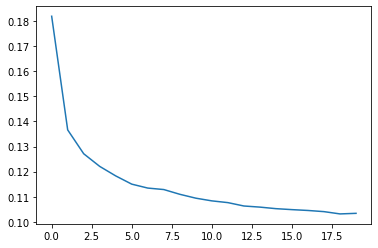

In [ ]:
plt.plot(history.history['loss'])

#### Take look at the final embeddings

In [ ]:
# Project data
z = encoder.predict(X)

Text(0.5, 1.0, 'UMAP embeddings')

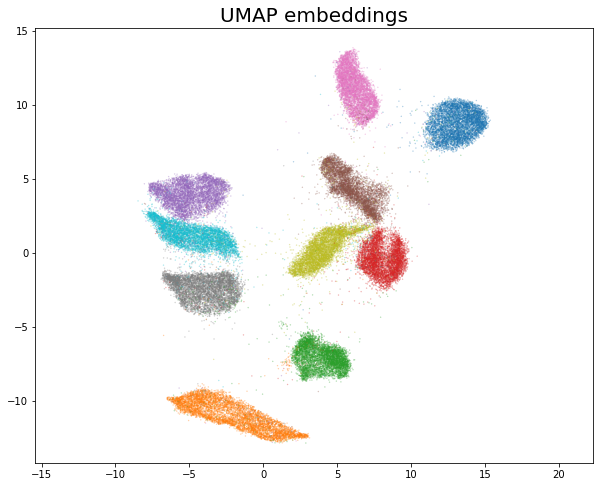

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)